In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
# mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [5]:
# build the dataset
block_size = 3 # context length

def build_dataset(words):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            index = stoi[ch]
            X.append(context)
            Y.append(index)
            context = context[1:] + [index] # "moving window"

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [6]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1]) # 80%
X_dev, Y_dev = build_dataset(words[n1:n2]) # 10%
X_test, Y_test = build_dataset(words[n2:]) # 10%

In [7]:
# MLP
n_embd = 10 # the dimensionality of the chracter embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * 5/3 / (n_embd * block_size)**0.5 # kaiming init
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

# BatchNorm parameters   ((result - mean) / std) * gain + bias
BN_gain = torch.ones((1, n_hidden))
BN_bias = torch.zeros((1, n_hidden))
BN_mean_running = torch.zeros((1, n_hidden))
BN_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, BN_gain, BN_bias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True  

12097


In [10]:
max_steps = 200000
batch_size = 32
loss_per_i = []

for i in range(max_steps):
    
    # minibatch construct
    index = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[index], Y_train[index]

    # forward pass
    emb = C[X_batch] # embed the characters into vectors
    emb_concat = emb.view(emb.shape[0], -1) # concarenate the vectors

    # linear layer
    hidden_pre_act = emb_concat @ W1 #+ b1 # hidden layer pre-activation

    # BatchNorm layer
    BN_mean_per_i = hidden_pre_act.mean(0, keepdim=True)
    BN_std_per_i = hidden_pre_act.std(0, keepdim=True)
    hidden_pre_act = BN_gain * (hidden_pre_act - BN_mean_per_i) / BN_std_per_i + BN_bias
    with torch.no_grad():
        BN_mean_running = 0.999 * BN_mean_running + 0.001 * BN_mean_per_i
        BN_std_running = 0.999 * BN_std_running + 0.001 * BN_std_per_i

    # non-linearity
    hidden = torch.tanh(hidden_pre_act) # hidden layer
    logits = hidden @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y_batch)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= learning_rate * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    loss_per_i.append(loss.log10().item())


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0198
 190000/ 200000: 2.1707


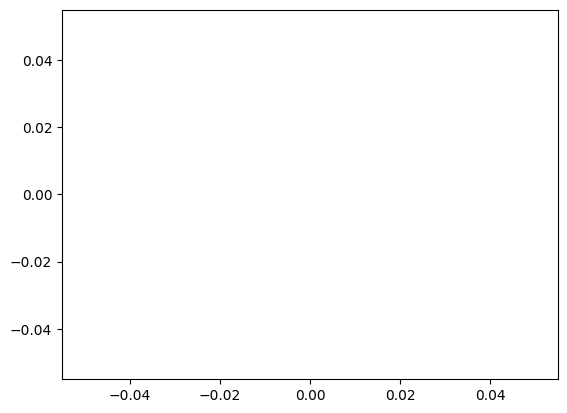

In [8]:
plt.plot(loss_per_i)

In [9]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[X_train]
    emb_concat = emb.view(emb.shape[0], -1)
    hidden_pre_act = emb_concat @ W1 # + b1
    # measure the mean/std over the entire training set
    BN_mean = hidden_pre_act.mean(0, keepdim=True)
    BN_std = hidden_pre_act.std(0, keepdim=True)

In [10]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    emb_concat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hidden_pre_act = emb_concat @ W1 # + b1
    hidden_pre_act = BN_gain * (hidden_pre_act - BN_mean_running) / BN_std_running + BN_bias
    hidden = torch.tanh(hidden_pre_act) # (N, n_hidden)
    logits = hidden @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.3020427227020264
val 3.300964117050171


In [11]:
# PYTORCHIFYING

class Linear:
    
    def __init__(self, num_of_inputs, num_of_neurons, bias = True):
        self.weight = torch.randn((num_of_inputs, num_of_neurons), generator=g) / num_of_inputs**0.5
        self.bias = torch.zeros(num_of_neurons) if bias else None

    def __call__(self, inputs):
        self.out = inputs @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (for training)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (for validating/testing)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, batch):
        # forward pass
        if self.training:
            batch_mean = batch.mean(0, keepdim=True)
            batch_var = batch.var(0, keepdim=True)
        else:
            batch_mean = self.running_mean
            batch_var = self.running_var
        
        batch_norm = (batch - batch_mean) / torch.sqrt(batch_var + self.eps)
        self.out = self.gamma * batch_norm + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

    
class Tanh:

    def __call__(self, input):
        self.out = torch.tanh(input)
        return self.out

    def parameters(self):
        return []

In [38]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [39]:
max_steps = 200000
batch_size = 32
loss_per_i = []
data = []

for i in range(max_steps):
    
    # minibatch construct
    index = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X_train[index], Y_train[index]

    # forward pass
    emb = C[X_batch] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concarenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_batch)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= learning_rate * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_per_i.append(loss.log10().item())
    with torch.no_grad():
        data.append([((learning_rate*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # if i >= 1000:
    #     break # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.2870
  10000/ 200000: 2.3273
  20000/ 200000: 2.1019
  30000/ 200000: 1.9020
  40000/ 200000: 2.1643
  50000/ 200000: 2.1520
  60000/ 200000: 1.7767
  70000/ 200000: 2.1514
  80000/ 200000: 2.3802
  90000/ 200000: 1.9338
 100000/ 200000: 2.3943
 110000/ 200000: 2.1620
 120000/ 200000: 2.1407
 130000/ 200000: 2.0210
 140000/ 200000: 1.7178
 150000/ 200000: 1.9393
 160000/ 200000: 1.9820
 170000/ 200000: 2.0205
 180000/ 200000: 2.2461
 190000/ 200000: 1.9766


layer 2 (      Tanh): mean +0.01, std 0.69, saturated: 15.56%
layer 5 (      Tanh): mean -0.02, std 0.74, saturated: 18.34%
layer 8 (      Tanh): mean +0.01, std 0.76, saturated: 17.56%
layer 11 (      Tanh): mean +0.01, std 0.78, saturated: 19.22%
layer 14 (      Tanh): mean +0.02, std 0.79, saturated: 19.38%


Text(0.5, 1.0, 'activation distribution')

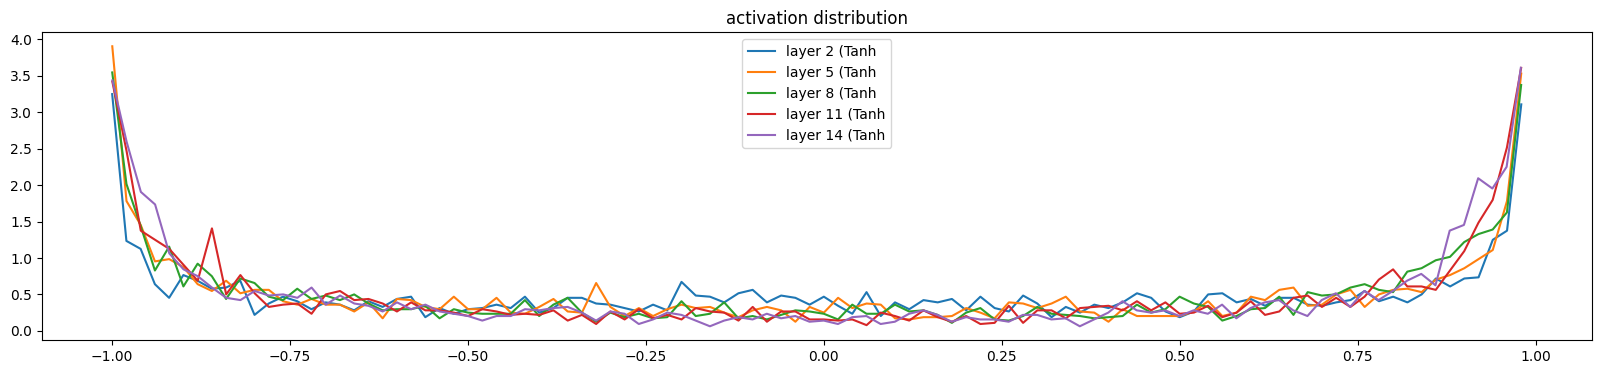

In [40]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.746502e-03
layer 5 (      Tanh): mean -0.000000, std 3.281705e-03
layer 8 (      Tanh): mean -0.000000, std 3.373798e-03
layer 11 (      Tanh): mean +0.000000, std 3.077419e-03
layer 14 (      Tanh): mean -0.000000, std 3.540037e-03


Text(0.5, 1.0, 'gradient distribution')

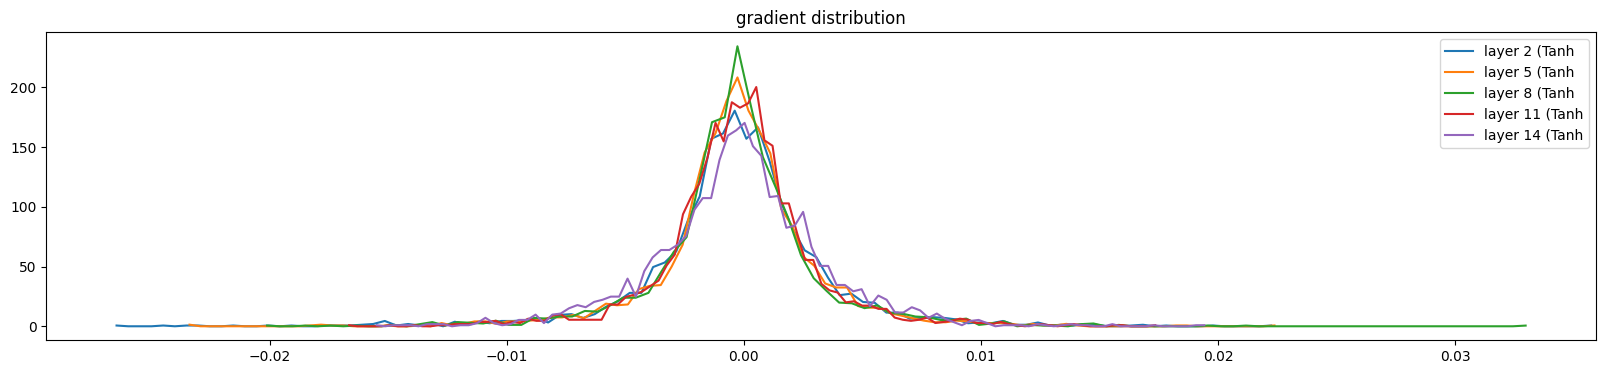

In [41]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.917114e-02 | grad:data ratio 1.765687e-02
weight  (30, 100) | mean +0.000015 | std 1.060940e-02 | grad:data ratio 3.003643e-02
weight (100, 100) | mean +0.000018 | std 6.144042e-03 | grad:data ratio 2.879055e-02
weight (100, 100) | mean +0.000069 | std 5.714682e-03 | grad:data ratio 2.718819e-02
weight (100, 100) | mean +0.000092 | std 5.485704e-03 | grad:data ratio 2.720412e-02
weight (100, 100) | mean +0.000042 | std 5.357336e-03 | grad:data ratio 2.822467e-02
weight  (100, 27) | mean -0.000141 | std 9.029409e-03 | grad:data ratio 2.934401e-02


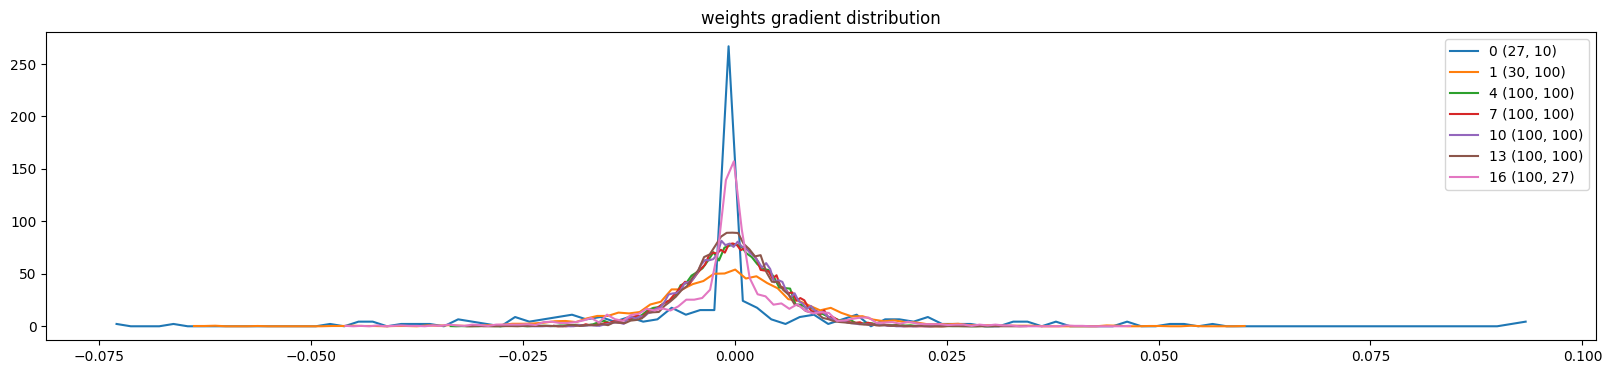

In [42]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

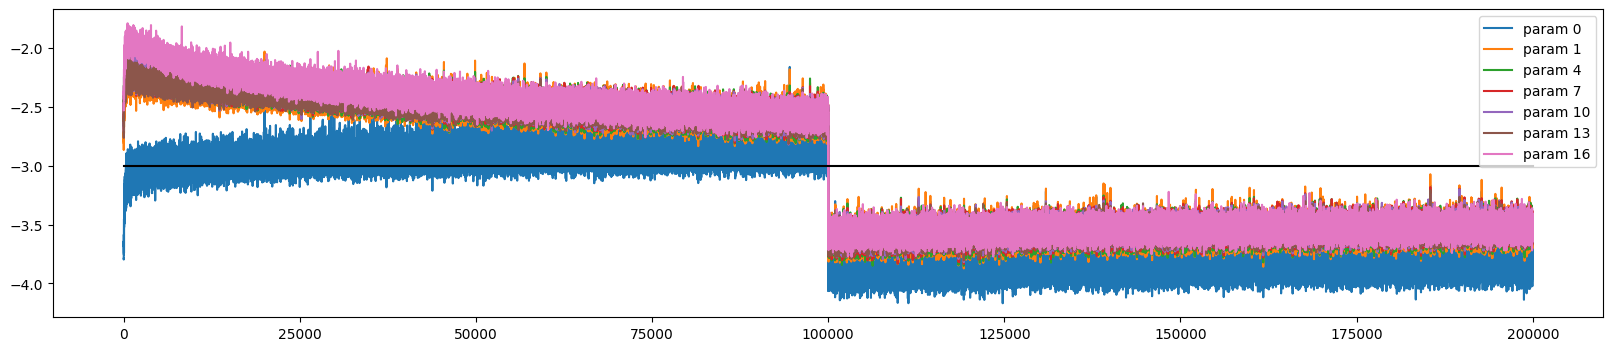

In [43]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([data[j][i] for j in range(len(data))])
        legends.append('param %d' % i)
plt.plot([0, len(data)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [44]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 2.0077316761016846
val 2.0803396701812744


In [45]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        probs = F.softmax(x, dim=1)
        # sample from the distribution
        index = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [index]
        out.append(index)
        # if we sample the special '.' token, break
        if index == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amelle.
khyimir.
reigh.
skanden.
jazhith.
deliah.
jareei.
nellara.
chaiivia.
leigh.
ham.
joce.
quintis.
lilea.
jadiquinte.
madiaryxia.
kaellissa.
med.
edi.


In [3]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
    g = torch.Generator().manual_seed(2147483647+1)
    x = torch.randn(5, generator=g) * 5
    x[0] = x0 # override the 0th example with the slider
    mu = x.mean()
    sig = x.std()
    y = (x - mu)/sig

    plt.figure(figsize=(10, 5))
    # plot 0
    plt.plot([-6,6], [0,0], 'k')
    # plot the mean and std
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
    # plot little lines connecting input and output
    for i in range(len(x)):
        plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
    # plot the input and output values
    plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
    plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
    plt.xlim(-6, 6)
    # title
    plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [5]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [6]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
